### Necessary import

In [1]:
import torch
import matplotlib.pyplot as plt

from lib.model.wgan import WGAN
from lib.utils import set_seed,to_numpy
from lib.augmentations import apply_augmentations, parse_augmentations
from lib.datasets import get_stock_price, train_test_split
from lib.network import get_generator, get_discriminator
from lib.test_metrics import get_standard_test_metrics
from lib.plot import plot_test_metrics,compare_hists,plot_summary

### Hyperparameter

In [2]:
wgan_config = {
    "batch_size" :128,
    "epoch" : 300,
    "lr_generator" : 5e-4,
    "lr_discriminator" : 5e-4,
    "discriminator_steps_per_generator_step" : 3,
    "augmentations": [
        {"name":  "AddTime"}
    ],
    "device" : "cuda:0" 
}
data_config = {
    "ticker" : "^GSPC",
    "interval" : "1d",
    "column" : 0,  
    "window_size" : 30,
    "dir" : "datasets",
    "subdir" : "stock"
}
D_config = {
    "discriminator_type": "ResFNN",
    "hidden_dims": [20,20],
}
logsig_config = {
    "generator_type": "LogSigRNN",
    "hidden_dim": 50,
    "augmentations": [
        {"name":  "AddTime"},
    ],
    "depth": 4,
    "input_dim": 10,
    "len_noise": 2000,
    "len_interval_u": 80,
    "init_fixed": True
}
lstm_config = {
  "generator_type": "LSTM",
  "hidden_dim": 50,
  "n_layers": 2,
  "init_fixed": True,
  "input_dim": 5
}

print(wgan_config['device'])

set_seed(2024)

cuda:0


In [3]:
if wgan_config.get('augmentations') is not None:
    wgan_config['augmentations'] = parse_augmentations(wgan_config.get('augmentations'))
if logsig_config.get('augmentations') is not None:
    logsig_config['augmentations'] = parse_augmentations(logsig_config.get('augmentations'))

### Load data and initialize discriminator and generator

In [4]:
x_real_rolled = get_stock_price(data_config)
x_real_rolled = x_real_rolled.to(wgan_config['device'])
print('Total data: ', list(x_real_rolled.shape))

x_real_dim: int = x_real_rolled.shape[2]

Rolled data for training, shape torch.Size([1480, 30, 1])
Total data:  [1480, 30, 1]


In [5]:
y = x_real_rolled
if logsig_config['augmentations'] is not None:
    D_input_dim = apply_augmentations(y,logsig_config["augmentations"]).shape[2]*data_config['window_size']
else: 
    D_input_dim = data_config['window_size']
print("D input dim: {}".format(D_input_dim))

D_config.update(input_dim=D_input_dim)
print(D_config)
logsig_config.update(output_dim=x_real_dim)
print(logsig_config)
lstm_config.update(output_dim=x_real_dim)
print(lstm_config)

ResFNN = get_discriminator(**D_config).to(wgan_config['device'])
logsig = get_generator(**logsig_config).to(wgan_config['device'])

ResFNN2 = get_discriminator(**D_config).to(wgan_config['device'])
lstm = get_generator(**lstm_config).to(wgan_config['device'])

D input dim: 60
{'discriminator_type': 'ResFNN', 'hidden_dims': [20, 20], 'input_dim': 60}
{'generator_type': 'LogSigRNN', 'hidden_dim': 50, 'augmentations': [AddTime()], 'depth': 4, 'input_dim': 10, 'len_noise': 2000, 'len_interval_u': 80, 'init_fixed': True, 'output_dim': 1}
{'generator_type': 'LSTM', 'hidden_dim': 50, 'n_layers': 2, 'init_fixed': True, 'input_dim': 5, 'output_dim': 1}
LogSigRNN input dim: 11


In [6]:
# Apply augmentations before initialize test metrics
# In convenience, x_real_test is set to be the same as x_real_rolled with augmentations.
x_real_test = apply_augmentations(x_real_rolled,logsig_config["augmentations"])

test_metrics = get_standard_test_metrics(x_real_test)

print("test_metrics_test: {}".format(test_metrics))

test_metrics_test: [SigW1Loss()]


### WGAN-GP

In [7]:
Logsig_WGAN = WGAN(ResFNN, logsig, 
                   x_real=x_real_rolled, 
                   test_metrics_test=test_metrics,
                   **wgan_config
)
Logsig_WGAN.fit(device=wgan_config['device'])

  0%|          | 0/300 [00:00<?, ?it/s]

augmentations: [AddTime()]
x_real shape: torch.Size([1480, 30, 2])


G_loss -8.622328e-01 D_loss 3.802160e-03: 100%|██████████| 300/300 [02:58<00:00,  1.68it/s] 


In [8]:
LSTM_WGAN = WGAN(ResFNN2, lstm, 
                   x_real=x_real_rolled, 
                   test_metrics_test=test_metrics,
                   **wgan_config
)
LSTM_WGAN.fit(device=wgan_config['device'])

G_loss 3.281217e-02 D_loss 1.379547e-01:   3%|▎         | 8/300 [00:00<00:04, 72.64it/s] 

augmentations: [AddTime()]
x_real shape: torch.Size([1480, 30, 2])


G_loss -1.486268e-01 D_loss 2.135227e-03: 100%|██████████| 300/300 [00:03<00:00, 77.81it/s] 


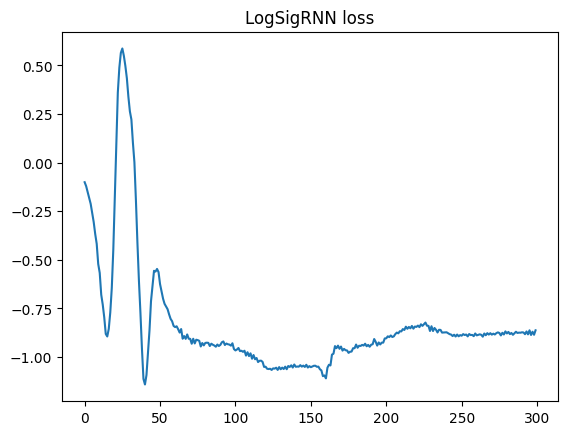

In [9]:
plt.plot(Logsig_WGAN.losses_history['G_loss'])
plt.title("LogSigRNN loss")
plt.show()

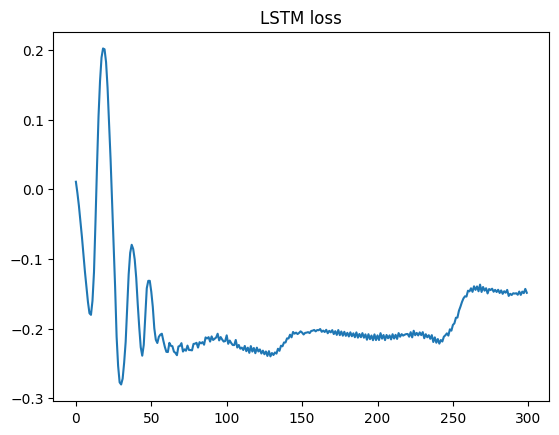

In [10]:
plt.plot(LSTM_WGAN.losses_history['G_loss'])
plt.title("LSTM loss")
plt.show()

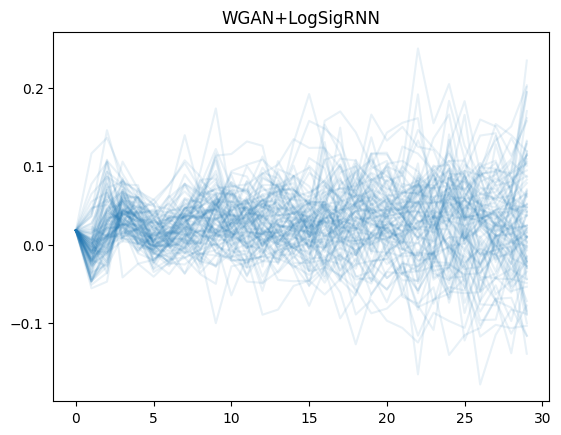

In [11]:
with torch.no_grad():
    x_fake = Logsig_WGAN.G(1024, data_config['window_size'], wgan_config['device'])

# print("x_real_dim:{}".format(x_real_dim))

for i in range(x_real_dim):
    plt.plot(to_numpy(x_fake[:100, :, i]).T, 'C%s' % i, alpha=0.1)
plt.title("WGAN+LogSigRNN")
plt.show()

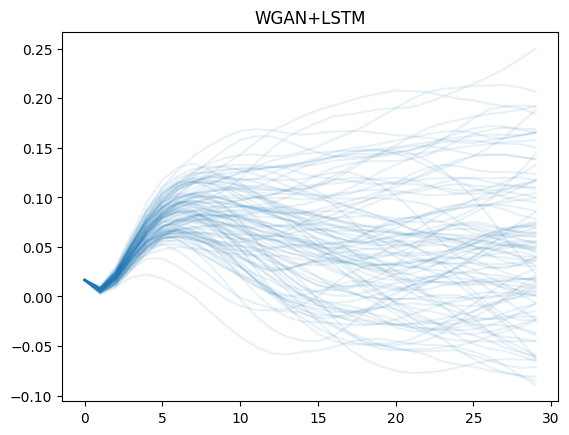

In [12]:
with torch.no_grad():
    lstm_x_fake = LSTM_WGAN.G(1024, data_config['window_size'], wgan_config['device'])

for i in range(x_real_dim):
    plt.plot(to_numpy(lstm_x_fake[:100, :, i]).T, 'C%s' % i, alpha=0.1)
plt.title("WGAN+LSTM")
plt.show()

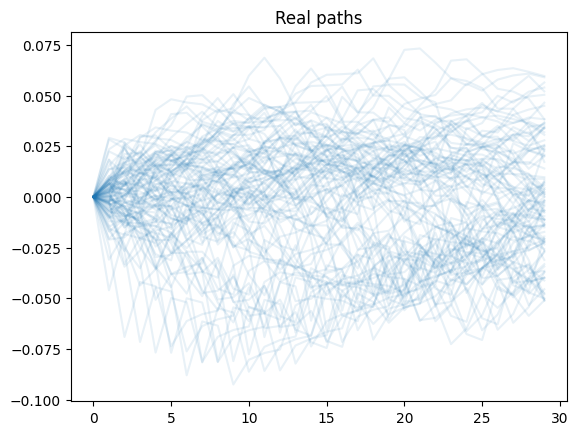

In [13]:
for i in range(x_real_dim):
    plt.plot(to_numpy(x_real_rolled[:100, :, i]).T, 'C%s' % i, alpha=0.1)
plt.title("Real paths")
plt.show()

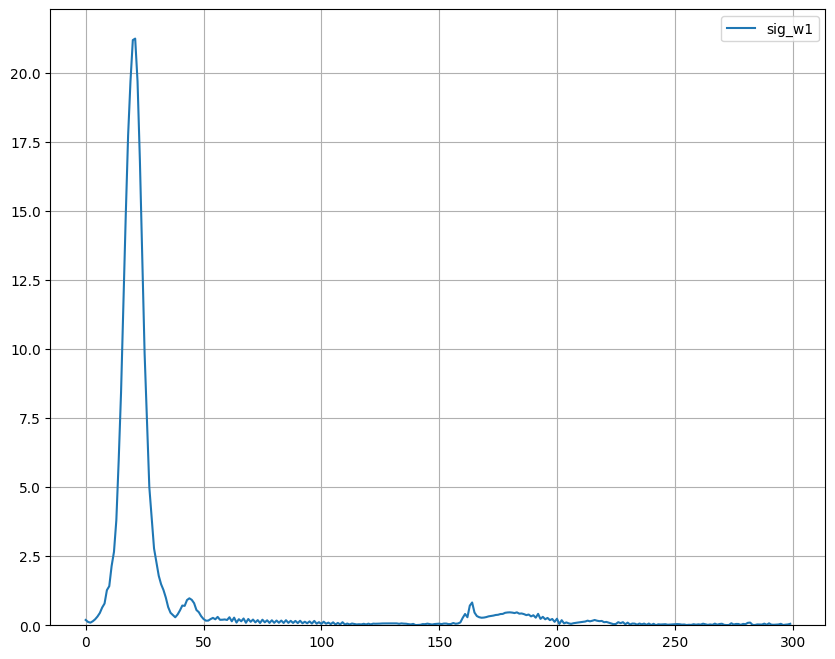

In [14]:
plot_test_metrics(test_metrics=Logsig_WGAN.test_metrics_test,losses_history=Logsig_WGAN.losses_history,mode="test")

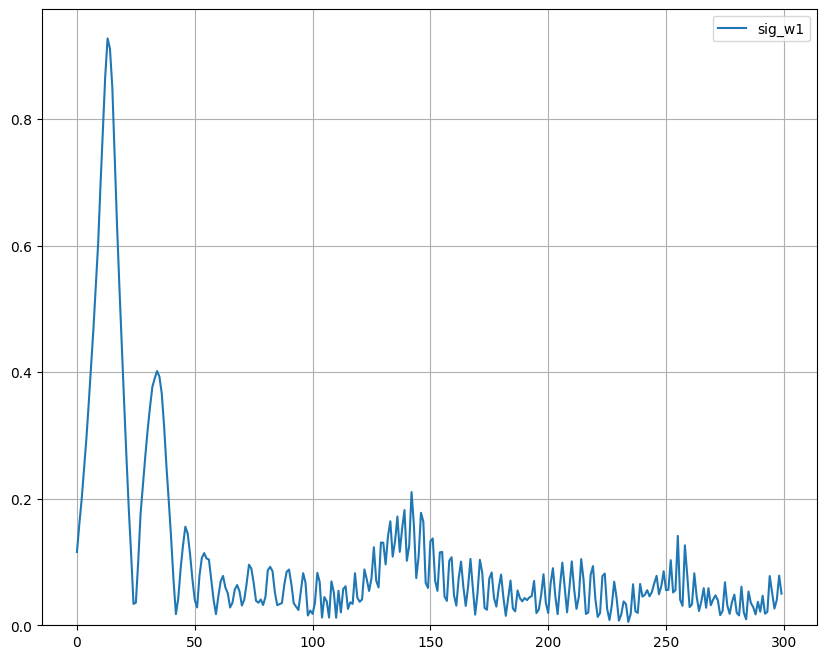

In [15]:
plot_test_metrics(test_metrics=LSTM_WGAN.test_metrics_test,losses_history=LSTM_WGAN.losses_history,mode="test")

<AxesSubplot:title={'center':'WGAN+LogSigRNN'}, ylabel='pdf'>

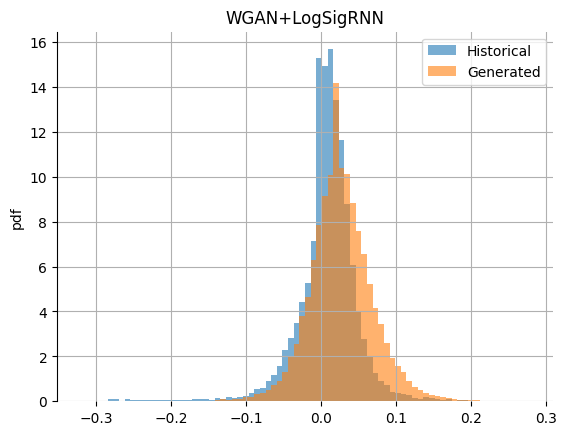

In [16]:
compare_hists(to_numpy(x_real_rolled[:1024]),to_numpy(x_fake),trainer="WGAN",G="LogSigRNN")

<AxesSubplot:title={'center':'WGAN+LSTM'}, ylabel='pdf'>

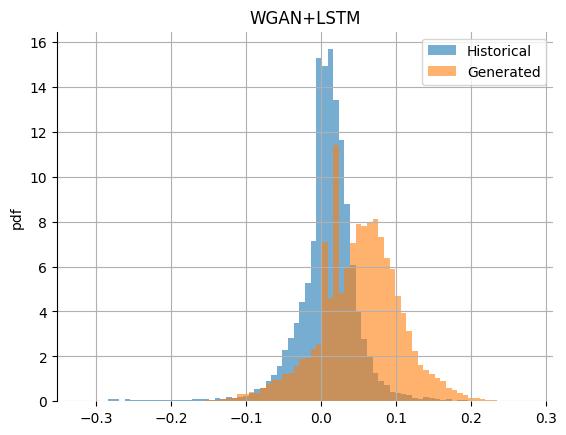

In [17]:
compare_hists(to_numpy(x_real_rolled[:1024]), to_numpy(lstm_x_fake),trainer="WGAN",G="LSTM")

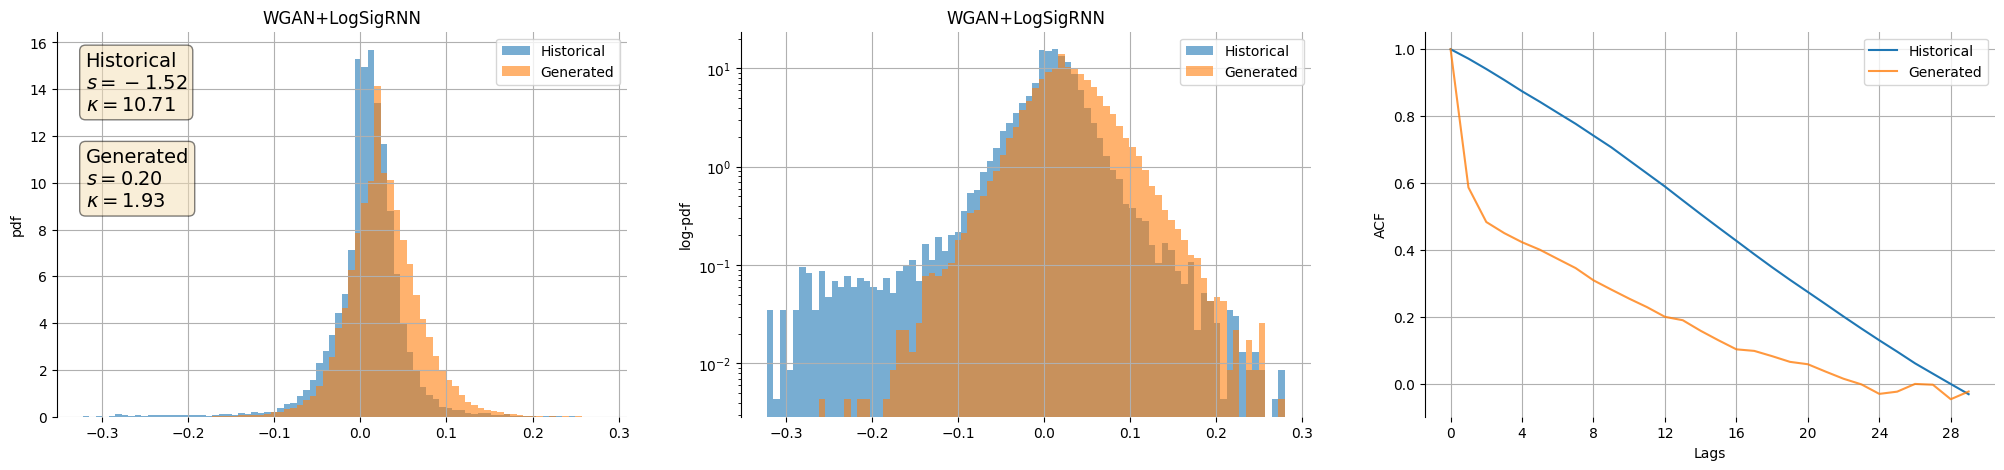

In [18]:
plot_summary(x_fake=x_fake,x_real=x_real_rolled[:1024],trainer="WGAN",G="LogSigRNN")

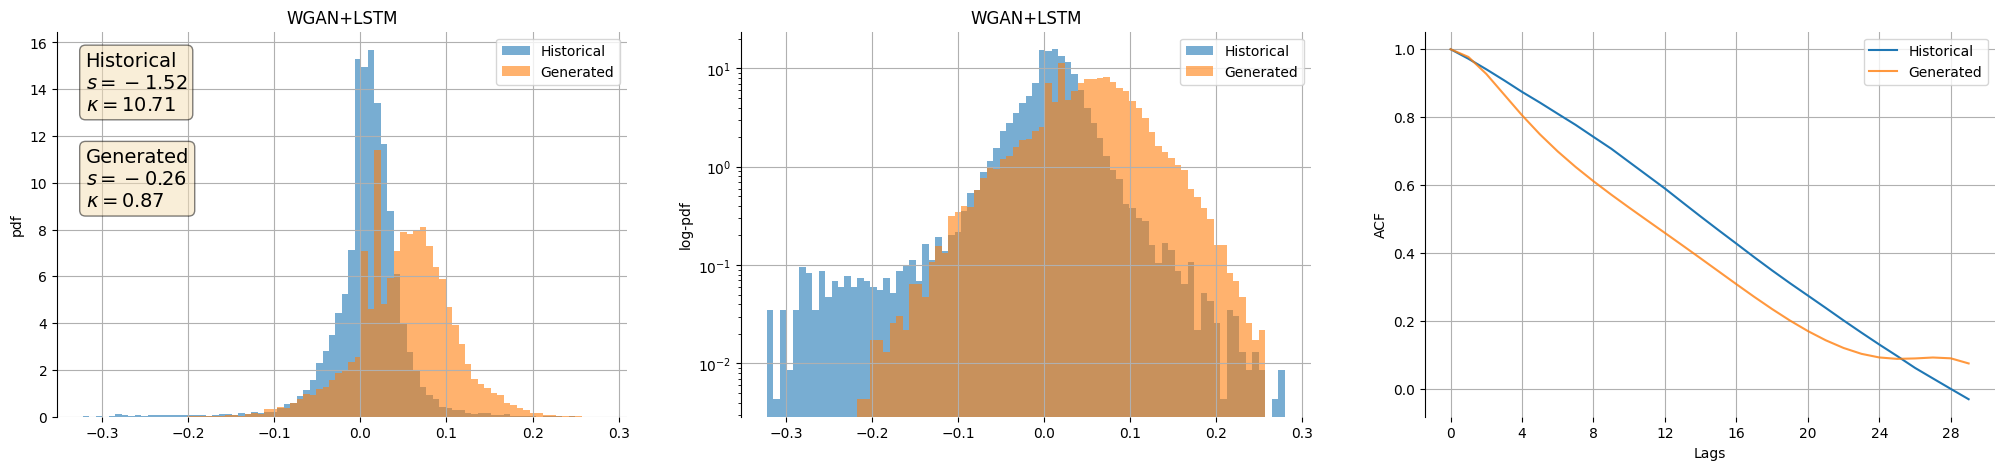

In [19]:
plot_summary(x_fake=lstm_x_fake,x_real=x_real_rolled[:1024],trainer="WGAN",G="LSTM")